In [227]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
import pickle
from types import SimpleNamespace
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize

from activephasemap.utils.settings import AutoPhaseMapDataSet

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [229]:
MIN_BIC_N_CLUSTERS = 3
DATA_DIR = "./sweep_phasemap/RUN3/"
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

In [230]:
# Construct data on a grid
grid_spectra = np.load("./grid/grid_spectra.npy")
grid_comps = np.load("./grid/grid_comps.npy")
t = np.linspace(0,1, grid_spectra.shape[1])

data = AutoPhaseMapDataSet(grid_comps, 
                           t, 
                           grid_spectra, 
                           )
data.generate(process=None)

In [231]:
with open(DATA_DIR+'/result_%d.pkl'%MIN_BIC_N_CLUSTERS, 'rb') as f:
    result = pickle.load(f)
out = SimpleNamespace(**result)

In [232]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 volume (µL)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    return ax

In [233]:
grid_comps.shape, grid_spectra.shape, out.delta_n.shape

((1000, 2), (1000, 101), (1000,))

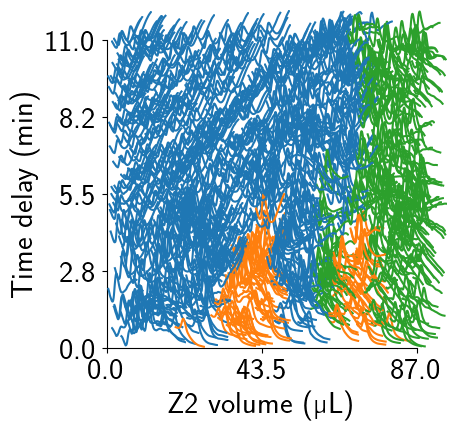

In [234]:
def plot(out, grid_comps, grid_spectra):
    bounds = np.asarray(design_space_bounds).T
    norm_grid_comps = normalize(grid_comps, bounds)
    fig, ax = plt.subplots(figsize=(4, 4))
    cmap = plt.get_cmap("tab10") 
    for i in range(grid_comps.shape[0]):
        loc_ax = ax.transLimits.transform(norm_grid_comps[i,:])
        ins_ax = ax.inset_axes([loc_ax[0],loc_ax[1],0.1,0.1])
        ins_ax.plot(t, grid_spectra[i,:], color=cmap(out.delta_n[i]))
        # ins_ax.set_ylim([0, grid_spectra.max()])
        ins_ax.axis("off")
    prettify_axis(ax)
    
    return fig, ax

with plt.style.context(pyplot_style):
    plot(out, grid_comps, grid_spectra)
    plt.show()

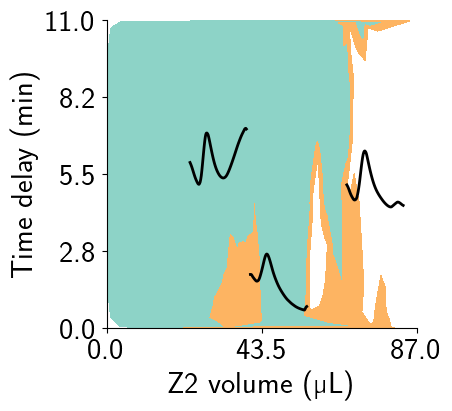

In [248]:
import matplotlib as mpl

cmap = plt.cm.Set3
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
boundaries = np.linspace(0, MIN_BIC_N_CLUSTERS, MIN_BIC_N_CLUSTERS+1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(4,4))
    for k in range(MIN_BIC_N_CLUSTERS):
        comps_k_mean = grid_comps[out.delta_n==k,:].mean(axis=0)
        norm_ci = normalize(comps_k_mean, np.asarray(design_space_bounds).T)
        loc_ax = ax.transLimits.transform(norm_ci)
        ins_ax = ax.inset_axes([loc_ax[0]-0.1,loc_ax[1]-0.1,0.2,0.2])
        ins_ax.plot(t, out.templates[k], color="k", lw=2.0)
        ins_ax.axis("off")
    ax.tricontourf(data.C[:,0], data.C[:,1], out.delta_n,
                   cmap=cmap, norm=norm)
    prettify_axis(ax)
    plt.savefig("./figures/phasemap_V2.png")
    plt.show()

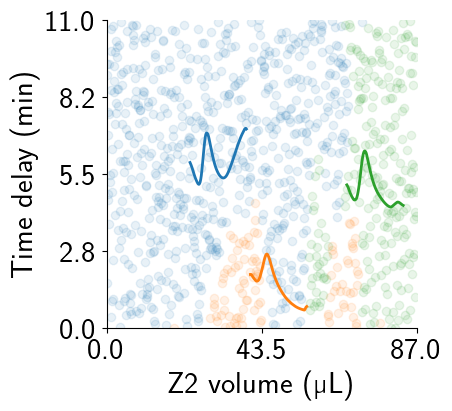

In [236]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(4,4))
    cmap = plt.get_cmap("tab10")

    for k in range(MIN_BIC_N_CLUSTERS):
        comps_k_mean = grid_comps[out.delta_n==k,:].mean(axis=0)
        norm_ci = normalize(comps_k_mean, np.asarray(design_space_bounds).T)
        loc_ax = ax.transLimits.transform(norm_ci)
        ins_ax = ax.inset_axes([loc_ax[0]-0.1,loc_ax[1]-0.1,0.2,0.2])
        ins_ax.plot(t, out.templates[k], color=cmap(k), lw=2.0)
        ins_ax.axis("off")
        # ins_ax.set_ylim([0, grid_spectra.max()])
    for k in range(MIN_BIC_N_CLUSTERS):
        ax.scatter(data.C[out.delta_n==k,0], data.C[out.delta_n==k,1], color=cmap(k), alpha=0.1)
    prettify_axis(ax)
    plt.savefig("./figures/phasemap_V3.png")
    plt.show()

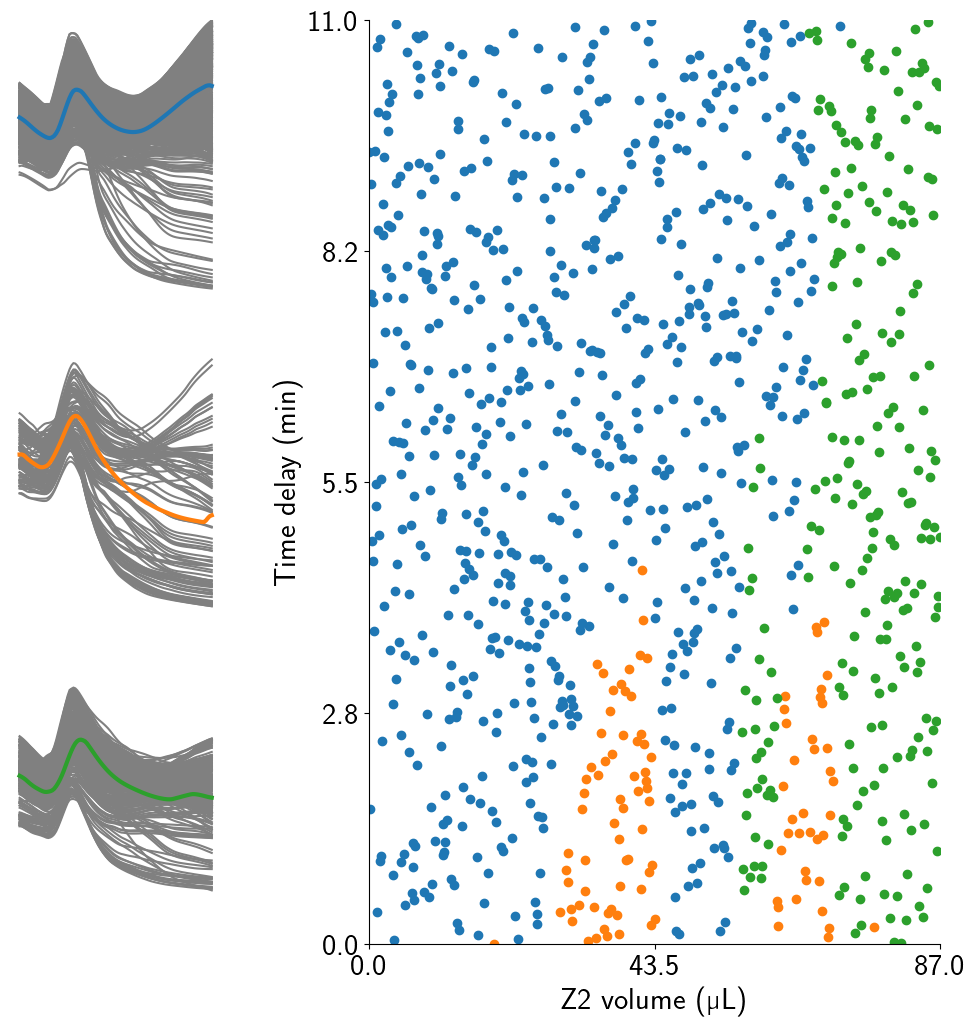

In [237]:
cmap = plt.get_cmap("tab10")

with plt.style.context(pyplot_style):
    if MIN_BIC_N_CLUSTERS==3:
        layout = [['A1','B', 'B'], 
                    ['A2', 'B', 'B'],
                    ['A3', 'B', 'B']
                    ]
        fig, axs = plt.subplot_mosaic(layout, figsize=(4*3, 4*3))
        ax_curves = [axs["A1"], axs["A2"], axs["A3"]]
    elif MIN_BIC_N_CLUSTERS==4:
        layout = [['A1', 'A2', 'B', 'B'], 
                    ['A3', 'A4', 'B', 'B'],
                    ]   
        fig, axs = plt.subplot_mosaic(layout, figsize=(4*4, 4*2)) 
        ax_curves = [axs["A1"], axs["A2"], axs["A3"], axs["A4"]]    
    fig.subplots_adjust(wspace=0.7, hspace=0.2)
    for k in range(MIN_BIC_N_CLUSTERS):
        Mk = np.argwhere(out.delta_n==k).squeeze()
        ax = ax_curves[k]
        for i in Mk:
            ax.plot(data.t, data.F[i], color='grey')

        ax.plot(data.t, out.templates[k], lw=3.0, color=cmap(k))
        ax.set_ylim([0, grid_spectra.max()]) 
        ax.axis('off')

        axs["B"].scatter(data.C[Mk,0], data.C[Mk,1], color=cmap(k))

    prettify_axis(axs["B"])
    plt.show()

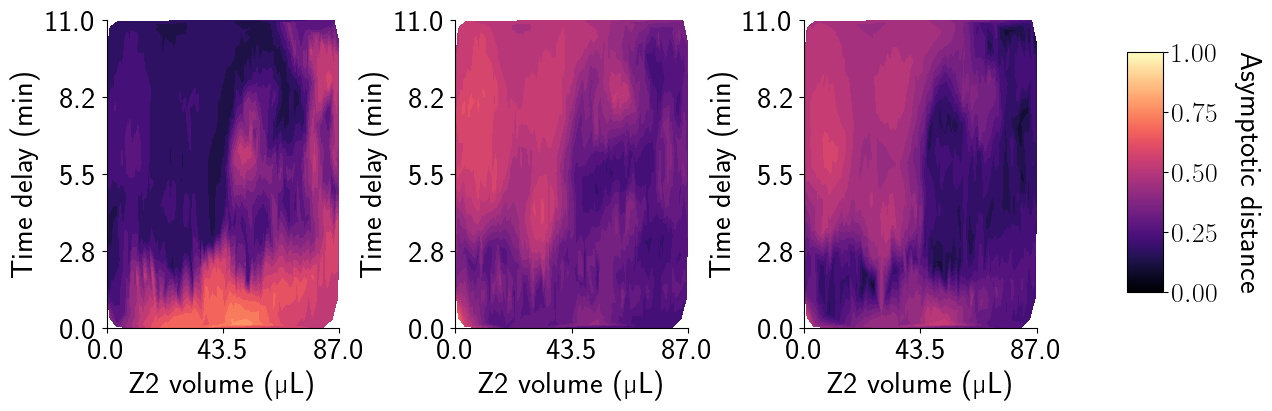

In [238]:
from matplotlib import cm
from matplotlib import colormaps
from matplotlib.colors import Normalize

cmap = colormaps["magma"]
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(1,MIN_BIC_N_CLUSTERS, figsize=(4*MIN_BIC_N_CLUSTERS, 4))
    fig.subplots_adjust(wspace=0.5)
    axs = axs.flatten()
    for k in range(MIN_BIC_N_CLUSTERS):
        ax = axs[k]
        ax.tricontourf(data.C[:,0], 
                       data.C[:,1], 
                       out.d_amplitude[:,k], 
                       15,
                       cmap=cmap,
                       norm = norm
                      )

        prettify_axis(ax)
    cax = plt.axes([0.975, 0.2, 0.03, 0.6])        
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_ylabel('Asymptotic distance', 
                       rotation=270, 
                       labelpad=32, 
                       fontsize=22
                       )
    plt.show()

### Visualize phase boundaries using contour lines

In [239]:
fig, ax = plt.subplots()

for k in range(MIN_BIC_N_CLUSTERS):
    comps_k_mean = grid_comps[out.delta_n==k,:].mean(axis=0)
    norm_ci = normalize(comps_k_mean, np.asarray(design_space_bounds).T)
    loc_ax = ax.transLimits.transform(norm_ci)
    ins_ax = ax.inset_axes([loc_ax[0]-0.1,loc_ax[1]-0.1,0.2,0.2])
    ins_ax.plot(t, out.templates[k], color="k", lw=2.0)
    ins_ax.axis("off")

boundaries = np.arange(0, MIN_BIC_N_CLUSTERS, 0.5)[1::2]
comp_grid_dim = int(np.sqrt(data.C.shape[0]))
ax.contour(data.C[:,0].reshape(comp_grid_dim, comp_grid_dim), 
           data.C[:,1].reshape(comp_grid_dim, comp_grid_dim), 
           out.delta_n.reshape(comp_grid_dim, comp_grid_dim),
           levels=boundaries, 
           colors='k', linestyles='-', linewidths=2.0
           )
plt.show()

ValueError: cannot reshape array of size 1000 into shape (31,31)

### Plot BIC trace over n_clusters sweep 
If the sweep data is available, plot the BIC sweep using errorbars

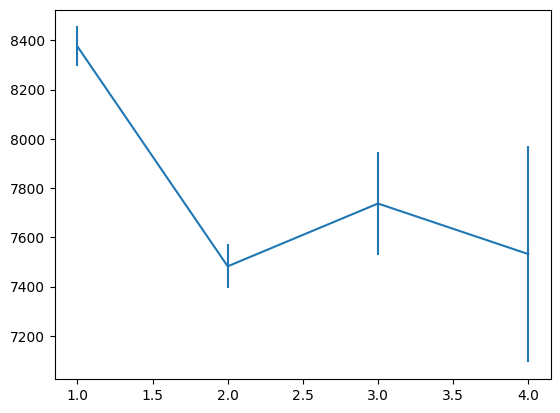

In [ ]:
N_CLUSTERS_MIN = 1
N_CLUSTERS_MAX = 4
bic = np.load(DATA_DIR+"/bic.npy")
fig, ax = plt.subplots()
ax.errorbar(np.arange(N_CLUSTERS_MIN, N_CLUSTERS_MAX+1), 
            bic.mean(axis=1),
            bic.std(axis=1)
)
plt.show()